In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import scipy as scipy
from scipy.stats import ttest_ind
import os

In [3]:
file_natural = pd.read_csv('results/natural/natural_imagebind_afforded.csv')
file_natural = file_natural.drop(columns=['Unnamed: 0'])
file_synthetic = pd.read_csv('results/synthetic/synthetic_imagebind_afforded.csv')
file_synthetic = file_synthetic.drop(columns=['Unnamed: 0'])

gpt_natural = pd.read_csv('gpt4v_results/df_natural.csv')
gpt_synthetic = pd.read_csv('gpt4v_results/df_synthetic.csv')

# GPT Main Result

In [58]:
def clean_df(df):
    df=df[['prompt_type','gpt4v_result_afforded','gpt4v_result_non_afforded','gpt4v_result_related']]
    df=df.rename(columns={'gpt4v_result_afforded':'afforded','gpt4v_result_non_afforded':'non_afforded','gpt4v_result_related':'related'})
    return df

gpt_n = gpt_natural.pipe(clean_df).assign(cat='natural')
gpt_s = gpt_synthetic.pipe(clean_df).assign(cat='synthetic')

df=pd.concat([gpt_n,gpt_s], axis=0)
all=df.melt(id_vars=['prompt_type','cat'], value_vars=['afforded','non_afforded','related']).rename(columns={'variable':'relationships'})
main=all.loc[all['relationships']!='related',:]

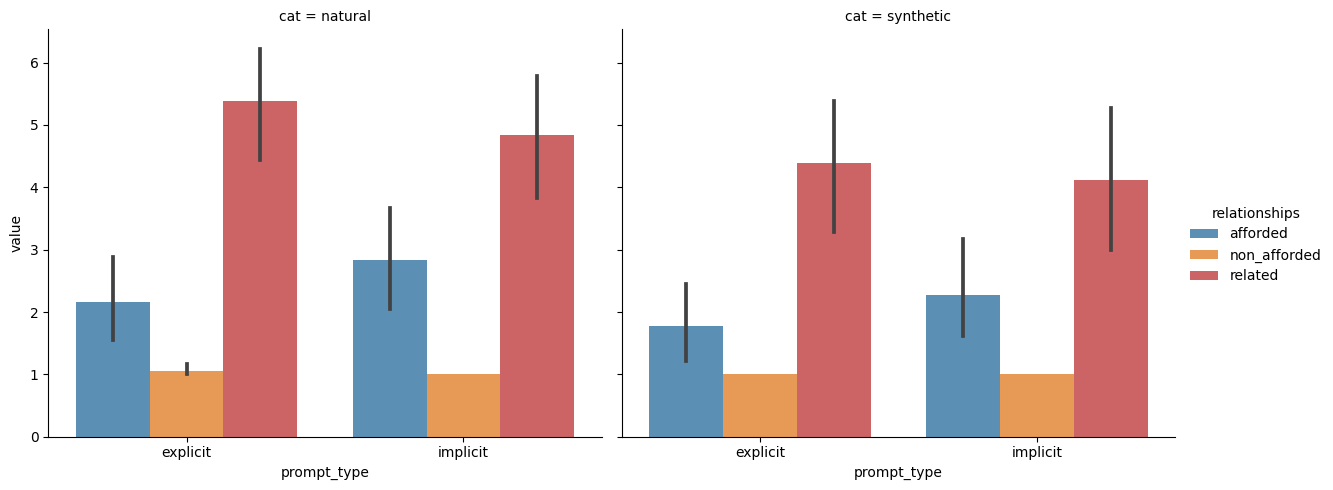

In [59]:
sns.catplot(data = all,
            x = "prompt_type",
            y = "value",
            hue = "relationships",
            col = "cat",
            kind='bar',
            height= 5,
            aspect=1.2,
            palette= ['C0','C1','C3'],
            alpha= 0.8)

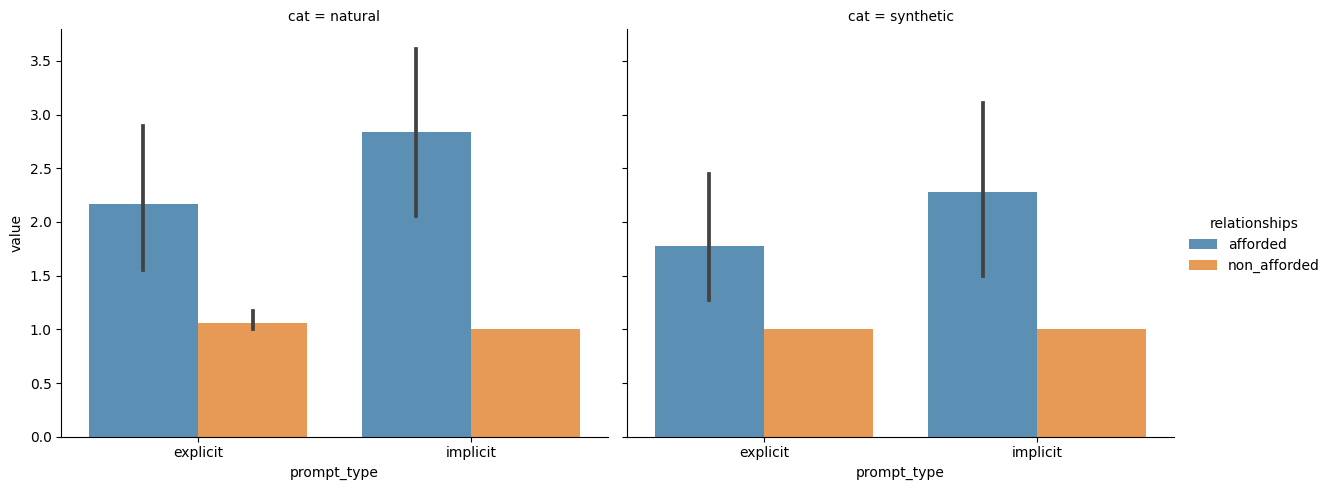

In [60]:
sns.catplot(data = main,
            x = "prompt_type",
            y = "value",
            hue = "relationships",
            col = "cat",
            kind='bar',
            height= 5,
            aspect=1.2,
            palette= ['C0','C1'],
            alpha= 0.8)

## Significance Results?

### ANOVA

In [62]:
model = ols('value ~ C(relationships) + C(prompt_type) + C(relationships):C(prompt_type)', data=all).fit()
anova_result = sm.stats.anova_lm(model, typ=2) 
print (anova_result,'\n')

                                     sum_sq     df          F        PR(>F)
C(relationships)                 500.333333    2.0  94.256666  6.116827e-30
C(prompt_type)                     0.115741    1.0   0.043608  8.347865e-01
C(relationships):C(prompt_type)    9.148148    2.0   1.723399  1.809728e-01
Residual                         557.361111  210.0        NaN           NaN 



### T Test Full Data Set

In [79]:
afforded = main.loc[main['relationships']=='afforded']
non_afforded = main.loc[main['relationships']=='non_afforded']
ttest_ind(afforded.loc[:,'value'], non_afforded.loc[:,'value'])

Ttest_indResult(statistic=6.53607294875467, pvalue=1.055367624871468e-09)

### T Test Separate Data Set

In [88]:
print('Natural Dataset T Test')
afforded = main.loc[(main['relationships']=='afforded') & (main['cat']=='natural')]
non_afforded = main.loc[(main['relationships']=='non_afforded') & (main['cat']=='natural')]
ttest_ind(afforded.loc[:,'value'], non_afforded.loc[:,'value'])

Natural Dataset T Test


Ttest_indResult(statistic=5.279674664135603, pvalue=1.3850139381863638e-06)

In [90]:
print('Synthetic Dataset T Test')
afforded = main.loc[(main['relationships']=='afforded') & (main['cat']=='synthetic')]
non_afforded = main.loc[(main['relationships']=='non_afforded') & (main['cat']=='synthetic')]
ttest_ind(afforded.loc[:,'value'], non_afforded.loc[:,'value'])

Synthetic Dataset T Test


/var/folders/yt/5gdjwln55x9_stgx851x0yb80000gn/T/ipykernel_64828/3008080949.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(afforded.loc[:,'value'], non_afforded.loc[:,'value'])


Ttest_indResult(statistic=3.9577285860251625, pvalue=0.00017930583782849128)

# ImageBind Main Results

In [20]:
# Import data from path
files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("results")) for f in fn]
results_files = [f for f in files if ".csv" in f]
tmp = []

for f in results_files:
    df_tmp = pd.read_csv(f)
    tmp.append(df_tmp)

df_concat = pd.concat(tmp)
df_concat = df_concat[df_concat.get('relationships') != 'related']
df_concat['dataset'].value_counts()
df_concat

,Unnamed: 0,relationships,prompt_type,probability,group_id,model,dataset
0,0,afforded,explicit,0.002712,1,imagebind,natural
1,1,afforded,explicit,0.009720,2,imagebind,natural
2,2,afforded,explicit,0.999069,3,imagebind,natural
3,3,afforded,explicit,0.999076,4,imagebind,natural
4,4,afforded,explicit,0.008987,5,imagebind,natural
...,...,...,...,...,...,...,...
67,67,non_afforded,implicit,0.033914,14,ViT-B-32,synthetic
68,68,non_afforded,implicit,0.005313,15,ViT-B-32,synthetic
69,69,non_afforded,implicit,0.118197,16,ViT-B-32,synthetic
70,70,non_afforded,implicit,0.632116,17,ViT-B-32,synthetic


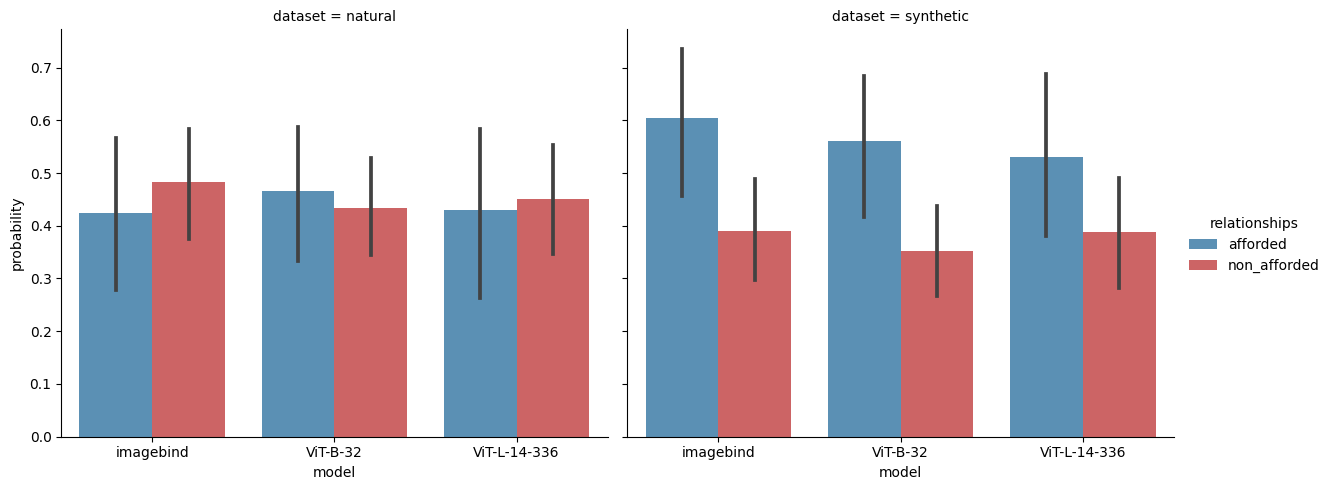

In [21]:
# Plots of Data
sns.catplot(data = df_concat,
            x = "model",
            y = "probability",
            hue = "relationships",
            col = "dataset",
            kind='bar',
            height= 5,
            aspect=1.2,
            palette= ['C0','C3'],
            alpha= 0.8)

# Bi-item Analysis

In [22]:
def pivot_fmp(df, ex_im):
    indexed = df[df['prompt_type']==ex_im]
    pivoted = indexed.pivot_table(index='group_id', columns='relationships', values='probability', aggfunc='mean').reset_index()
    diff = pivoted.assign(diff = abs(pivoted['afforded'] - pivoted['non_afforded']), new_id = np.arange(18))

    return diff

def plot_fmp(df, ex_im, na_sy):
    plot = sns.catplot(data = df,
                       x = "new_id",
                       y = "diff",
                       kind='bar',
                       height= 3,
                       aspect=1.5,
                       palette= ['C0','C3'],
                       alpha= 0.8).set(title = f'Abs difference for {ex_im} {na_sy} data')
    return plot


In [23]:
diff_ex_natural = pivot_fmp(file_natural, 'explicit')
diff_im_natural = pivot_fmp(file_natural, 'implicit')
diff_ex_synthetic = pivot_fmp(file_synthetic, 'explicit')
diff_im_synthetic = pivot_fmp(file_synthetic, 'implicit')

## Absolute Value Differences Analysis

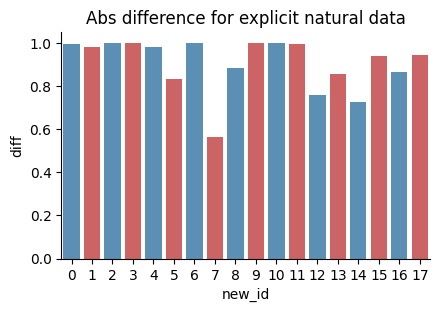

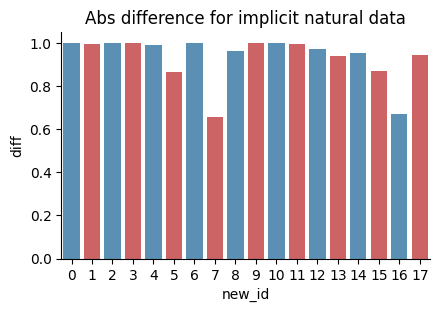

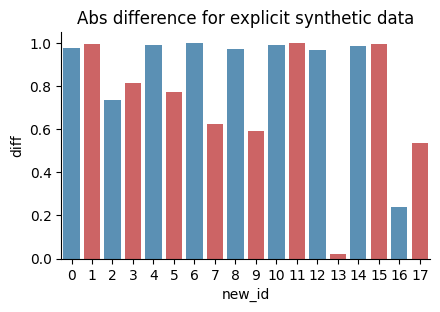

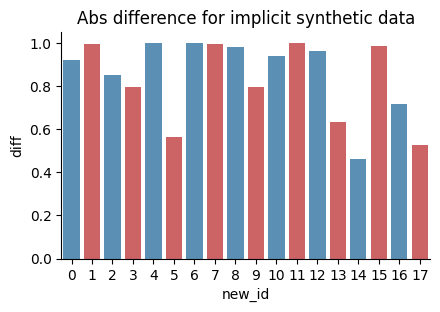

In [24]:
plot_fmp(diff_ex_natural, 'explicit', 'natural')
plot_fmp(diff_im_natural, 'implicit', 'natural')
plot_fmp(diff_ex_synthetic, 'explicit', 'synthetic')
plot_fmp(diff_im_synthetic, 'implicit', 'synthetic')

## Non-Absolute Differences Analysis

In [25]:
# Re-load files
file_natural = pd.read_csv('results/natural/natural_imagebind_afforded.csv')
file_natural = file_natural.drop(columns=['Unnamed: 0'])

file_synthetic = pd.read_csv('results/synthetic/synthetic_imagebind_afforded.csv')
file_synthetic = file_synthetic.drop(columns=['Unnamed: 0'])

In [26]:
# Prelim check of ids
natural_group_ids = set(file_natural['group_id'].unique())
synthetic_group_ids = set(file_synthetic['group_id'].unique())
print(natural_group_ids)
print(synthetic_group_ids)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


In [27]:
# Pivot for non-absolute
def pivot_fmp_non_abs(df, ex_im):
    indexed = df[df['prompt_type'] == ex_im]
    pivoted = indexed.pivot_table(index='group_id', columns='relationships', 
                                  values='probability', aggfunc='mean').reset_index()
    non_abs_diff = pivoted.assign(diff = pivoted['afforded'] - pivoted['non_afforded'],
                                  new_id = np.arange(len(pivoted)))

    return non_abs_diff

In [28]:
def plot_fmp_non_abs(df, ex_im, na_sy):
    plot = sns.catplot(data = df,
                       x = "new_id",
                       y = "diff",
                       kind='bar',
                       height= 3,
                       aspect=1.5,
                       palette= ['C0'],
                       alpha= 0.8).set(title = f'Difference for {ex_im} {na_sy} data')
    return plot

In [29]:
def correlate_differences(natural_explicit, natural_implicit, synthetic_explicit, synthetic_implicit):
    common_groups_nat = set(natural_explicit['group_id']).intersection(set(natural_implicit['group_id']))
    common_groups_syn = set(synthetic_explicit['group_id']).intersection(set(synthetic_implicit['group_id']))

    # Filter dfs
    nat_exp_common = natural_explicit[natural_explicit['group_id'].isin(common_groups_nat)]
    nat_imp_common = natural_implicit[natural_implicit['group_id'].isin(common_groups_nat)]
    syn_exp_common = synthetic_explicit[synthetic_explicit['group_id'].isin(common_groups_syn)]
    syn_imp_common = synthetic_implicit[synthetic_implicit['group_id'].isin(common_groups_syn)]

    # Calculate corr
    corr_nat_exp_vs_imp = nat_exp_common['diff'].corr(nat_imp_common['diff'])
    corr_syn_exp_vs_imp = syn_exp_common['diff'].corr(syn_imp_common['diff'])

    common_groups_explicit = set(natural_explicit['group_id']).intersection(set(synthetic_explicit['group_id']))
    common_groups_implicit = set(natural_implicit['group_id']).intersection(set(synthetic_implicit['group_id']))

    # Filter dfs (explicit and implicit prompts across datasets)
    nat_explicit_common = natural_explicit[natural_explicit['group_id'].isin(common_groups_explicit)]
    syn_explicit_common = synthetic_explicit[synthetic_explicit['group_id'].isin(common_groups_explicit)]
    nat_implicit_common = natural_implicit[natural_implicit['group_id'].isin(common_groups_implicit)]
    syn_implicit_common = synthetic_implicit[synthetic_implicit['group_id'].isin(common_groups_implicit)]

    # Calculate corr (cross dataset)
    corr_explicit_nat_vs_syn = nat_explicit_common['diff'].corr(syn_explicit_common['diff'])
    corr_implicit_nat_vs_syn = nat_implicit_common['diff'].corr(syn_implicit_common['diff'])

    return corr_nat_exp_vs_imp, corr_syn_exp_vs_imp, corr_explicit_nat_vs_syn, corr_implicit_nat_vs_syn

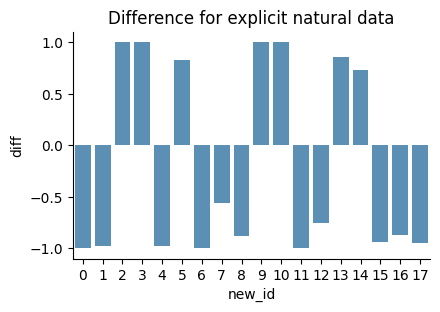

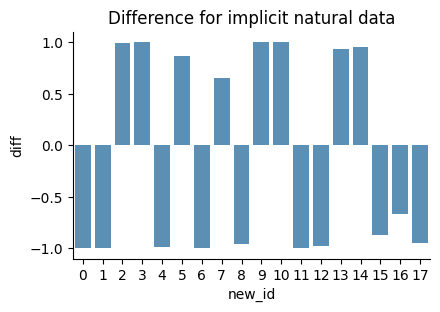

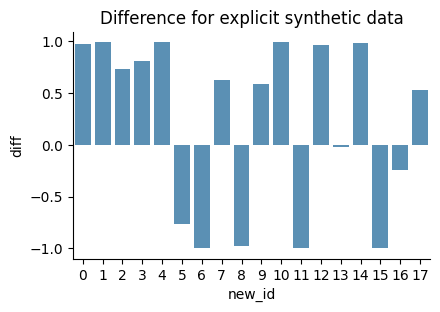

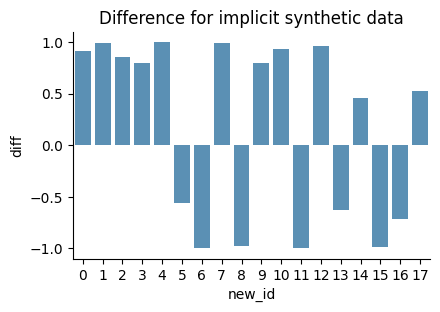

In [30]:
# Calculate non-abs diff
diff_ex_natural_non_abs = pivot_fmp_non_abs(file_natural, 'explicit')
diff_im_natural_non_abs = pivot_fmp_non_abs(file_natural, 'implicit')
diff_ex_synthetic_non_abs = pivot_fmp_non_abs(file_synthetic, 'explicit')
diff_im_synthetic_non_abs = pivot_fmp_non_abs(file_synthetic, 'implicit')

# Plot
plot_fmp_non_abs(diff_ex_natural_non_abs, 'explicit', 'natural')
plot_fmp_non_abs(diff_im_natural_non_abs, 'implicit', 'natural')
plot_fmp_non_abs(diff_ex_synthetic_non_abs, 'explicit', 'synthetic')
plot_fmp_non_abs(diff_im_synthetic_non_abs, 'implicit', 'synthetic')

## Correlation Analysis

In [15]:
def analyze_correlations(natural_explicit, natural_implicit, synthetic_explicit, synthetic_implicit):
    # Compute
    corr_nat_exp_vs_imp, corr_syn_exp_vs_imp, corr_explicit_nat_vs_syn, corr_implicit_nat_vs_syn = correlate_differences(
        natural_explicit, natural_implicit, synthetic_explicit, synthetic_implicit
    )

    # Print
    print(f"Correlation between explicit and implicit prompts within natural dataset: {corr_nat_exp_vs_imp}")
    print(f"Correlation between explicit and implicit prompts within synthetic dataset: {corr_syn_exp_vs_imp}")
    print(f"Correlation of explicit prompts between natural and synthetic datasets: {corr_explicit_nat_vs_syn}")
    print(f"Correlation of implicit prompts between natural and synthetic datasets: {corr_implicit_nat_vs_syn}")

analyze_correlations(diff_ex_natural_non_abs, diff_im_natural_non_abs, 
                     diff_ex_synthetic_non_abs, diff_im_synthetic_non_abs)

Correlation between explicit and implicit prompts within natural dataset: 0.9505623670647826
Correlation between explicit and implicit prompts within synthetic dataset: 0.9564549504540861
Correlation of explicit prompts between natural and synthetic datasets: 0.2702873906952157
Correlation of implicit prompts between natural and synthetic datasets: 0.2634577764819398


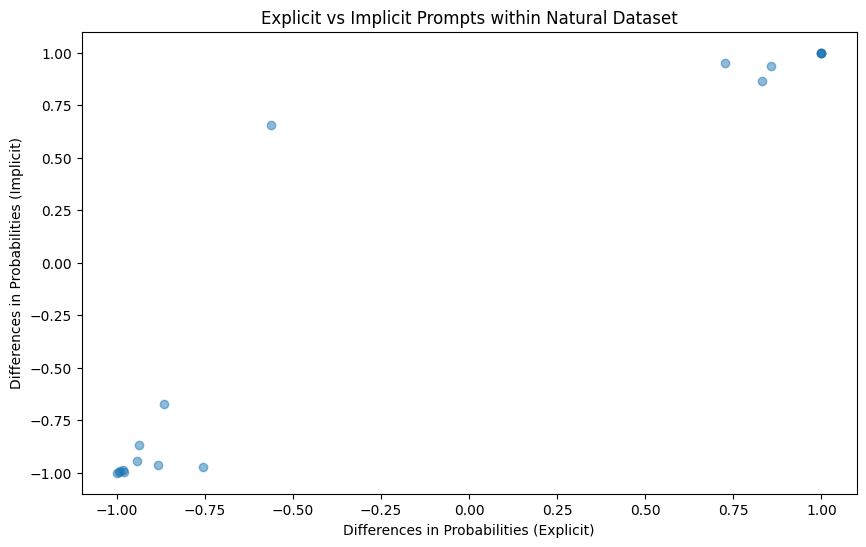

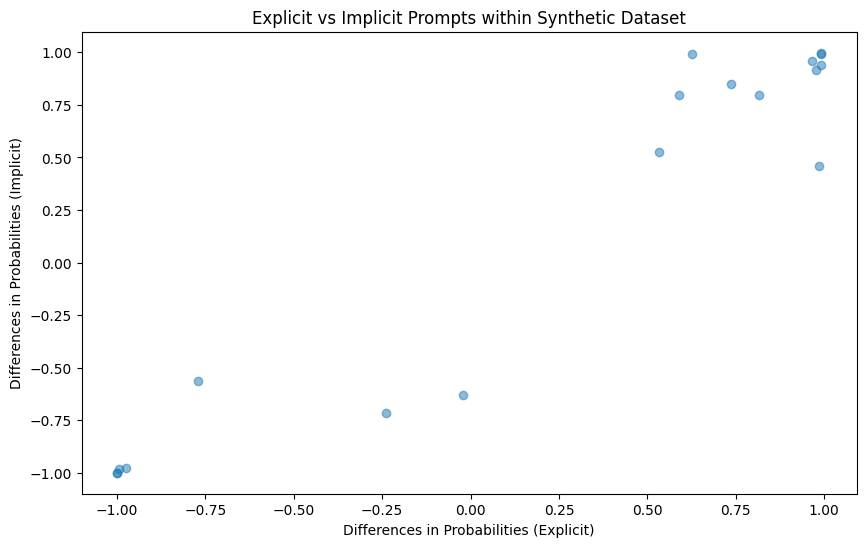

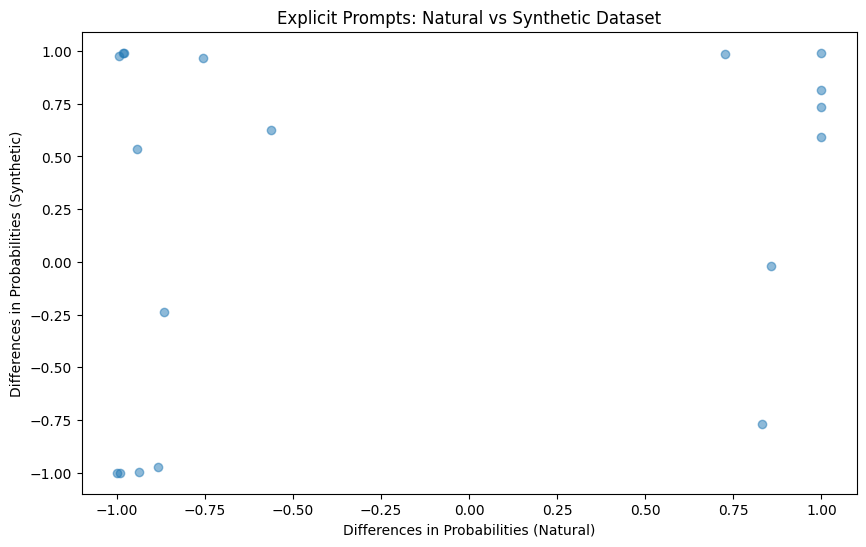

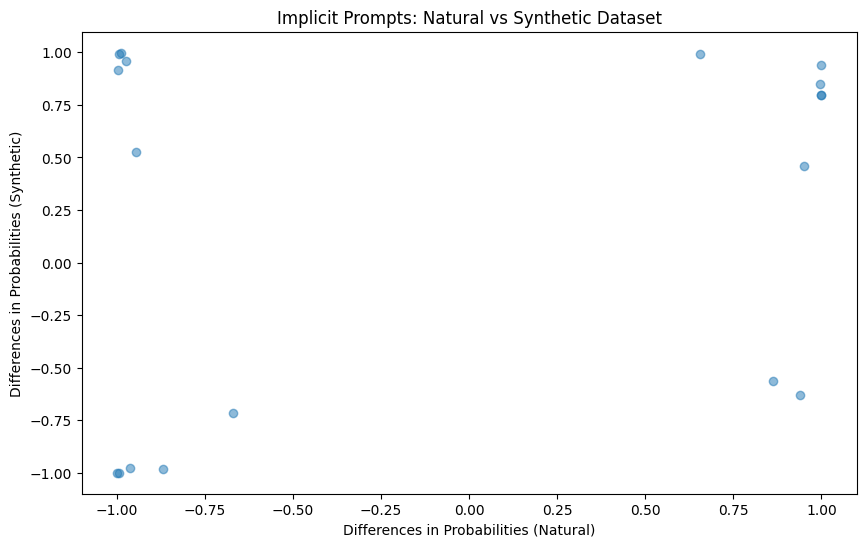

In [16]:
# Explicit vs Implicit within Natural
plt.figure(figsize=(10, 6))
plt.scatter(diff_ex_natural_non_abs['diff'], diff_im_natural_non_abs['diff'], alpha=0.5)
plt.title('Explicit vs Implicit Prompts within Natural Dataset')
plt.xlabel('Differences in Probabilities (Explicit)')
plt.ylabel('Differences in Probabilities (Implicit)')
plt.show()

# Explicit vs Implicit within Synthetic
plt.figure(figsize=(10, 6))
plt.scatter(diff_ex_synthetic_non_abs['diff'], diff_im_synthetic_non_abs['diff'], alpha=0.5)
plt.title('Explicit vs Implicit Prompts within Synthetic Dataset')
plt.xlabel('Differences in Probabilities (Explicit)')
plt.ylabel('Differences in Probabilities (Implicit)')
plt.show()

# Explicit Prompts between Natural and Synthetic
plt.figure(figsize=(10, 6))
plt.scatter(diff_ex_natural_non_abs['diff'], diff_ex_synthetic_non_abs['diff'], alpha=0.5)
plt.title('Explicit Prompts: Natural vs Synthetic Dataset')
plt.xlabel('Differences in Probabilities (Natural)')
plt.ylabel('Differences in Probabilities (Synthetic)')
plt.show()

# Implicit Prompts between Natural and Synthetic
plt.figure(figsize=(10, 6))
plt.scatter(diff_im_natural_non_abs['diff'], diff_im_synthetic_non_abs['diff'], alpha=0.5)
plt.title('Implicit Prompts: Natural vs Synthetic Dataset')
plt.xlabel('Differences in Probabilities (Natural)')
plt.ylabel('Differences in Probabilities (Synthetic)')
plt.show()